# This is the notebook to generate data for Core_shell
# Experiments are generated one by one with different config file and core_size. See Core_shell for individual config files.

In [ ]:
import os
import json
import pathlib
import numpy as np
import pandas as pd
from dda import DDA
np.random.seed(0)
current_folder_path = pathlib.Path().absolute()
# Assign atom types according to the ratio below and save atomList to the experimental folder
exp_index = '/exp1'

# Generate the atomic model of the core-shell structure before simulation

In [ ]:
# read in the overall atoms
atom_list = pd.read_csv(str(current_folder_path)+'/Core_shell'+'/atomList_Octahedron.csv',delimiter=",",header=None)
# read in the gold core; in this eample the core is 20 nm octahedra. It means there is not silver on the shell at all. 
core = pd.read_csv(str(current_folder_path)+'/Core_shell'+exp_index+'/atomList_Octahedron20.csv',delimiter=",",header=None)
core_positions = np.around(np.array(core.iloc[:,1:]),7).tolist()
# convert everything to Ag first
atom_list.iloc[:,0] = 'Ag'
atom_list_position = np.around(np.array(atom_list.iloc[:,1:]),7)
# loop through all the existing atoms
for i in range(len(atom_list_position)):
    # if it's part of the core
    if atom_list_position[i].tolist() in core_positions:
        # the atom type is Au
        atom_list.iloc[i,0] = 'Au'
atom_list.to_csv(str(current_folder_path)+'/Core_shell' + exp_index +'/atomList_Octahedron.csv',index=False,header=False)

# Define config file for simulation

In [ ]:
# GPU Device Config
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="3"


config = {'gpu_device': '/GPU:0',
          'dipole_length': 1,
          'min_wavelength': 0.4,
          'max_wavelength': 0.8,
          'num_wavelengths': 41,
          'ref_medium': 1.333,
          'rotation_steps': 10,
          'folder_path': None,
          'calculate_electricField': False,
          'lattice_constant': 0.41,
          'ref_data': [str(current_folder_path) + '/Au_ref_index.csv',str(current_folder_path) + '/Ag_ref_index.csv'],
          'metals': ["Au","Ag"],
          'dipole_data': str(current_folder_path)+'/Core_shell' + '/dipole_list.csv',
          'atom_data': str(current_folder_path)+'/Core_shell' + exp_index + '/atomList_Octahedron.csv',
          "ratio":None,
          "method":"heter_atomic",
          "custom_ratio_path":None,
        }

In [ ]:
config['folder_path'] = str(current_folder_path) + '/Core_shell' + exp_index
with open(config['folder_path']+'/config.json','w') as outfile:
    json.dump(config,outfile)
# define the DDA object
np_dda = DDA(config)

In [ ]:
# perform the calculation
np_dda.run_DDA()
np_dda.plot_spectra()

# When all the simulations were complete, analyze the data

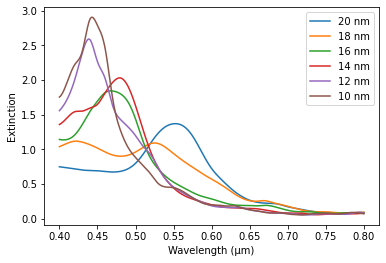

In [13]:
current_folder_path = pathlib.Path().absolute()
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
for i in range(1,7):
    data = np.loadtxt(str(current_folder_path) + '/Core_shell' + f'/exp{i}/Results.csv',delimiter=',')
    function = interp1d(np.linspace(0.4,0.8,41),data,"cubic")
    data = function(np.linspace(0.4,0.8,1000))
    plt.plot(np.linspace(0.4,0.8,1000),data,label = f'{22-2*i} nm')
    plt.xlabel("Wavelength (μm)")
    plt.ylabel("Extinction")
    plt.legend()
    plt.savefig('Au_Ag_coreshell.png',dpi=300)